# This notebook has 2 tasks:
## 1. Explore association between critical genes and neurological diseases
## 2. Explore coexpression between critical genes and DEGs

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sys import platform 
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'

# Load critical gene lists (with subselection method)

In [2]:
critical_gene_path = prefix + '/Shared drives/NIAAA_ASSIST/Data/feature_extraction_derived/'
critical_gene_dfs = []
embedding_names = []
for file in os.listdir(critical_gene_path):
    if file.startswith('module') and file.endswith('.csv'):
        df = pd.read_csv(critical_gene_path + '/' + file)
        critical_gene_dfs.append(df)
        embedding_names.append('_'.join(file.split('_')[:3]))

In [3]:
from opentargets import OpenTargetsClient
client = OpenTargetsClient()
response = client.filter_associations()

C:\Users\bbche\miniconda3\lib\site-packages\opentargets\conn.py:299: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.api_specs = yaml.load(self.swagger_yaml)


In [13]:
cg_lists1 = []
for i in range(5):
    cg_lists1 += [gene for gene in critical_gene_dfs[i]['gene'][:20]]

In [14]:
neuro_dict1 = {}
for gene in cg_lists1:
    cnt = 0
    response.filter(target = gene, scorevalue_min = 0.7)
    for r in response:
        if ('nervous' in r['disease']['efo_info']['label'].lower()) or ('neuro' in r['disease']['efo_info']['label'].lower()):
            cnt += 1
    if cnt > 0:
        gene = r['target']['gene_info']['symbol']
        neuro_dict1[gene] = cnt

In [166]:
len(neuro_dict1)

22

In [4]:
from collections import OrderedDict
def plot_target_disease(disease_dict):
    plt.figure(figsize = (len(disease_dict)/3.5,4))
    sorted_dict = dict(sorted(disease_dict.items(), key = lambda x:x[1], reverse=True))
    plt.bar(sorted_dict.keys(), sorted_dict.values())
    plt.xticks(rotation = 45, ha = 'right')
    plt.ylabel('# associated neuro diseases')
    plt.title('Open target search')

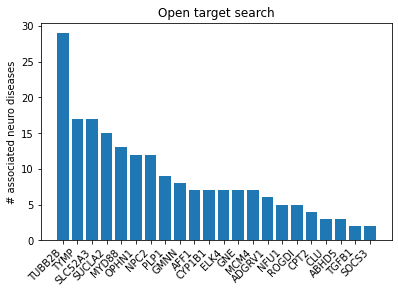

In [164]:
plot_target_disease(neuro_dict1)

# Load critical gene list (with whole network embedding method)

In [3]:
critical_gene_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/feature_extraction_derived/epoch=100_alpha=0.1_critical_gene_df.csv')
cg_list2 = critical_gene_df['gene'][:100]

In [16]:
neuro_dict2 = {}
for gene in cg_list2:
    cnt = 0
    response.filter(target = gene, scorevalue_min = 0.7)
    for r in response:
        if ('nervous' in r['disease']['efo_info']['label'].lower()) or ('neuro' in r['disease']['efo_info']['label'].lower()):
            cnt += 1
    if cnt > 0:
        gene = r['target']['gene_info']['symbol']
        neuro_dict2[gene] = cnt

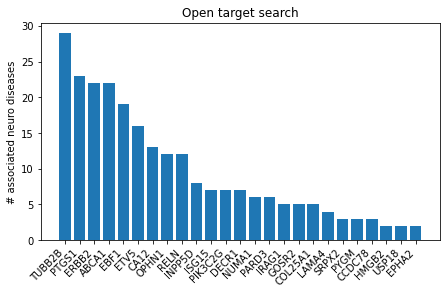

In [165]:
plot_target_disease(neuro_dict2)

# Search Open Target with DEGs

In [4]:
deseq = pd.read_excel(prefix + '/Shared drives/NIAAA_ASSIST/Data/deseq.alc.vs.control.age.rin.batch.gender.PMI.corrected.w.prot.coding.gene.name.xlsx')

In [5]:
deseq['abs_log2FC'] = abs(deseq['log2FoldChange'])
deseq.sort_values('abs_log2FC', ascending = False, inplace = True)

In [9]:
neuro_dict3 = {}
cg_list3 = deseq['id'][:100]
for gene in cg_list3:
    cnt = 0
    response.filter(target = gene, scorevalue_min = 0.7)
    for r in response:
        if ('nervous' in r['disease']['efo_info']['label'].lower()) or ('neuro' in r['disease']['efo_info']['label'].lower()):
            cnt += 1
    if cnt > 0:
        gene = r['target']['gene_info']['symbol']
        neuro_dict3[gene] = cnt

In [106]:
for k in neuro_dict2:
    print(k)
for k in neuro_dict3:
    print(k)

ERBB2
ABCA1
HMGB2
LAMA4
ISG15
ETV5
USP18
IRAG1
OPHN1
RELN
GOSR2
NUMA1
PIK3C2G
CA12
EBF1
INPP5D
SRPX2
COL25A1
PARD3
PYGM
PTGS1
EPHA2
DECR1
CCDC78
TUBB2B
TRPC3
PIK3C2G
FREM1
CXCL12
SRPX2
PROM1
SDC4
HMCN1
ERBB2
CACNA1S
EDN3
CA12
TAL1
HMGB2
BAG3
CCND1
PTPRQ
LIPC
LUM
RELN
OTOGL
ELN
SELP
KCNK10
PYGM
EMCN
RLBP1
VEGFC
CDHR1
TFCP2L1
APOC1
PDK4
STON2


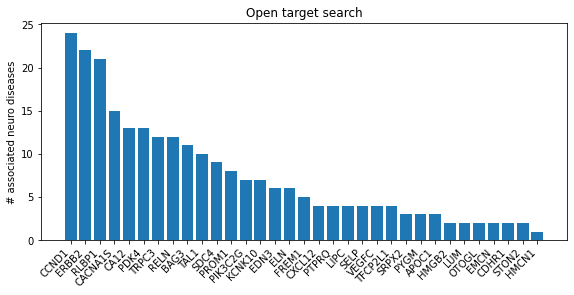

In [10]:
plot_target_disease(neuro_dict3)

# Use GeneNetwork2 (http://gn2.genenetwork.org/) to find the expression data and perform correlation analysis

In [2]:
def plot_corr_data(expression, deg_list, gene_list, gene_list_type):
    corr_df = expression.iloc[:,1:].apply(pd.to_numeric).corr()
    deg_cols = corr_df.columns[corr_df.columns.isin(deg_list)]
    gene_cols = corr_df.columns[corr_df.columns.isin(gene_list)]
    relevant_corr = corr_df[gene_cols].loc[deg_cols] # get only the cg columns and deg rows 
#     sort_corr1 = relevant_corr[relevant_corr.mean().sort_values().index] # sort columns by column mean
#     sort_corr2 = sort_corr1.reindex(sort_corr1.mean(axis = 1).sort_values().index) # sort index by index mean
    plt.rcParams.update({'font.size':14})
    plt.figure(figsize = (14, 11))
    g = sns.clustermap(relevant_corr, cmap = 'RdBu_r', vmin = -1, vmax = 1)
    if gene_list_type == 'critical':
        xlabel = 'Critical genes'
    elif gene_list_type == 'neighbor':
        xlabel = 'Neighbor genes'
    else:
        print(f'gene_list_type {gene_list_type} is not recognized')
        xlabel = ''
    g.ax_heatmap.set_xlabel(xlabel)
    g.ax_heatmap.set_ylabel('DEGs')
    avg_corr = round(np.mean(abs(relevant_corr).mean()),2)
    g.ax_heatmap.set_title(f'Average |corr|: {avg_corr}', y = 1.35)
    plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha = 'right')
    return relevant_corr

## Corr1: Critical genes from whole network vs DEGs with GTEX data

In [6]:
deg_list = deseq['id'][:50]
cg_list = cg_list2[:50]

In [231]:
with open(f'../../data/genes_to_search.txt', 'w') as file:
    for gene in deg_list:
        file.writelines(f'{gene}\n')
    for gene in cg_list:
        file.writelines(f'{gene}\n')

In [7]:
def clean_gtex(gtex_file):
    gtex = pd.read_csv(gtex_file, skiprows = 12)
#     gtex_dict = {gtex.columns[i]:gtex.loc[0][i] for i in range(1, len(gtex.columns))}
    gtex.columns = gtex.loc[0]
    gtex = gtex.iloc[1:,:]
    gtex_clean = gtex.loc[20:].replace('x', np.NaN)
    return gtex_clean

In [8]:
gtex_v8 = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\GTEx_v8_traits.csv', skiprows = 12)

In [9]:
gene_dict = {gtex_v8.columns[i]:gtex_v8.loc[0][i] for i in range(1, len(gtex_v8.columns))}

In [10]:
gtex_v8.columns = gtex_v8.loc[0]
gtex_v8 = gtex_v8.iloc[1:,:]
gtex_clean = gtex_v8.loc[20:].replace('x', np.NaN)

In [11]:
deg_list_convert = list(map(gene_dict.get, deg_list))
cg_list_convert = list(map(gene_dict.get, cg_list))

<Figure size 1008x792 with 0 Axes>

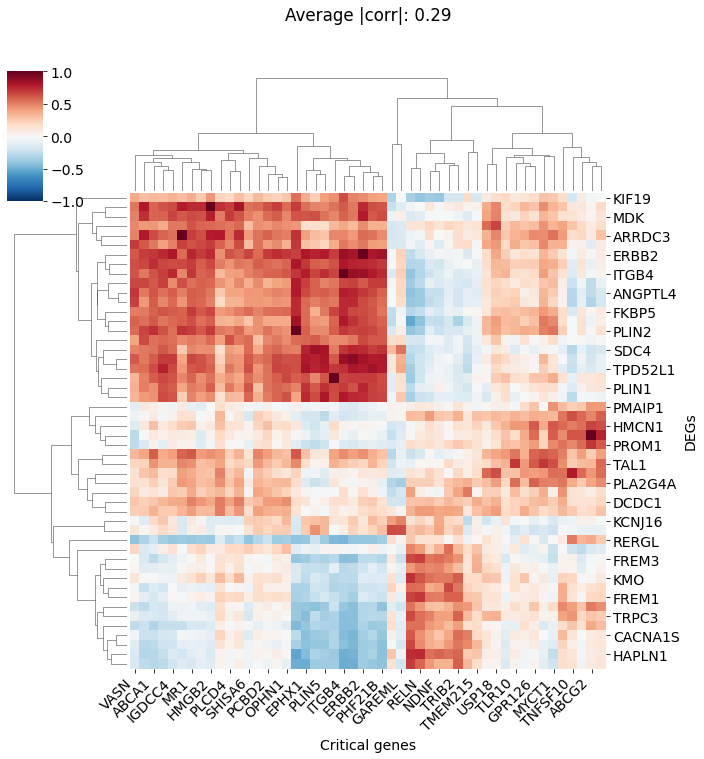

In [14]:
sorted_corr_df1 = plot_corr_data(gtex_clean, deg_list_convert, cg_list_convert, 'critical')

## Corr2: Plot critical genes vs DEGs with Kapoor expression data

In [48]:
expression = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/kapoor2019_batch.age.rin.sex.pm.alc.corrected.coga.inia.expression.txt', sep = '\t')

In [43]:
gene_dict = pd.Series(deseq.gene.values, index = deseq.id).to_dict()

In [52]:
def get_gene_expression(deg_list, cg_list, expression_df, gene_dict):
    '''Get the subset expression data for deg and cg list only'''
    genes_to_query = deg_list + cg_list
    expression_to_use = expression_df[expression_df['id'].isin(genes_to_query)]
    expression_to_use = expression_to_use.assign(id = expression_to_use.id.map(gene_dict))
    expression_to_use.index = expression_to_use.id
    expression_to_use.drop(columns = 'id', inplace=True)
    expression_to_use_t = expression_to_use.T
    return expression_to_use_t

In [53]:
expression_to_use1 = get_gene_expression(deg_list.tolist(), cg_list.tolist(), expression, gene_dict)

In [54]:
len(expression_to_use1)

139

<Figure size 1008x792 with 0 Axes>

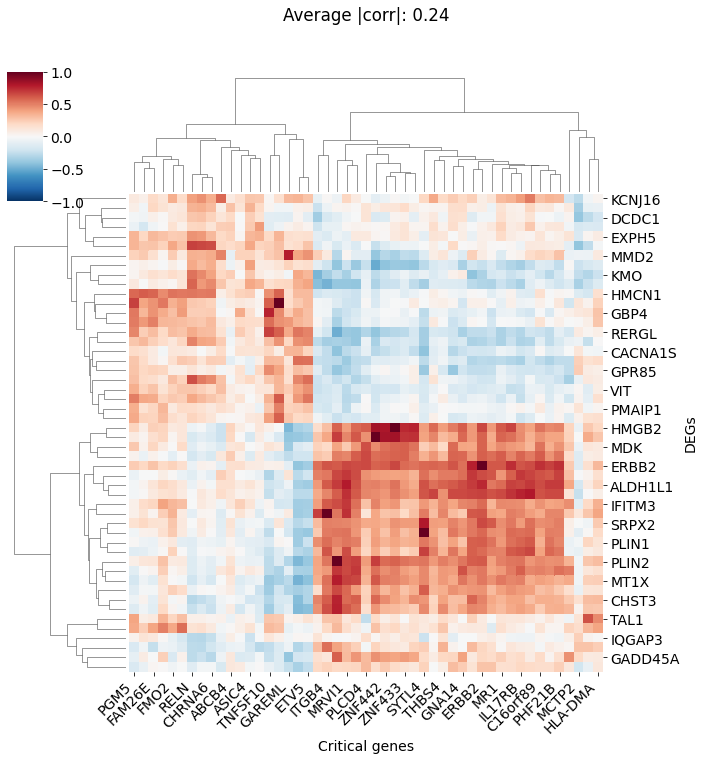

In [55]:
sorted_corr_df2 = plot_corr_data(expression_to_use1, deg_list_convert, cg_list_convert, 'critical')

## Corr3: Important genes vs DEGs with GTEX data

### Get top 51 "important" genes from the network and determine how much correlation there is between DEGs and "important" genes using GTEX data. "Important" genes are defined as the closest neighbors to DEGs in the network

In [27]:
def get_network_important_genes(subnetwork_w_de, cutoff = 0.03, abs_log2FC_cutoff = 0.2):
    '''Search important genes by edge weights'''
    network_important_gene_dict = {}
    for col in subnetwork_w_de.columns[:-2]:
        subset = subnetwork_w_de[(subnetwork_w_de[col].between(cutoff, 0.99)) & (subnetwork_w_de['abs_log2FC'] > abs_log2FC_cutoff)][col]
        if len(subset) > 0:
            network_important_gene_dict[col] = len(subset)
    return network_important_gene_dict

In [13]:
def join_network_w_deseq(network, deseq):
    if 'abs_log2FC' not in deseq.columns:
        deseq['abs_log2FC'] = abs(deseq['log2FoldChange'])
    network_w_DE = pd.merge(network, deseq[['id','abs_log2FC']], left_index = True, right_on = 'id')
    network_w_DE.index = network_w_DE['id']
    return network_w_DE

In [17]:
%%time
tom_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/Kapoor_TOM.csv', index_col = 0) 
tom_w_deseq = join_network_w_deseq(tom_df, deseq)

Wall time: 5min 56s


In [18]:
tom_important_genes = get_network_important_genes(tom_w_deseq, cutoff = 0.142)

In [46]:
print('# important genes not in the cg list')
len(set(tom_important_genes.keys()) - set(cg_list))

# important genes not in the cg list


51

In [138]:
# export the gene list to query with Gene Network
with open(f'../../data/genes_to_search2.txt', 'w') as file:
    for gene in deg_list:
        file.writelines(f'{gene}\n')
    for gene in tom_important_genes.keys():
        file.writelines(f'{gene}\n')

In [19]:
gtex_important_genes = clean_gtex(prefix + '/Shared drives/NIAAA_ASSIST/Data/GTEx_v8_traits_important_genes.csv')

In [23]:
gene_dict = pd.Series(deseq.gene.values, index = deseq.id).to_dict()

In [24]:
deg_list_convert = list(map(gene_dict.get, deg_list))
important_list_convert = list(map(gene_dict.get, list(tom_important_genes.keys())))

<Figure size 1008x792 with 0 Axes>

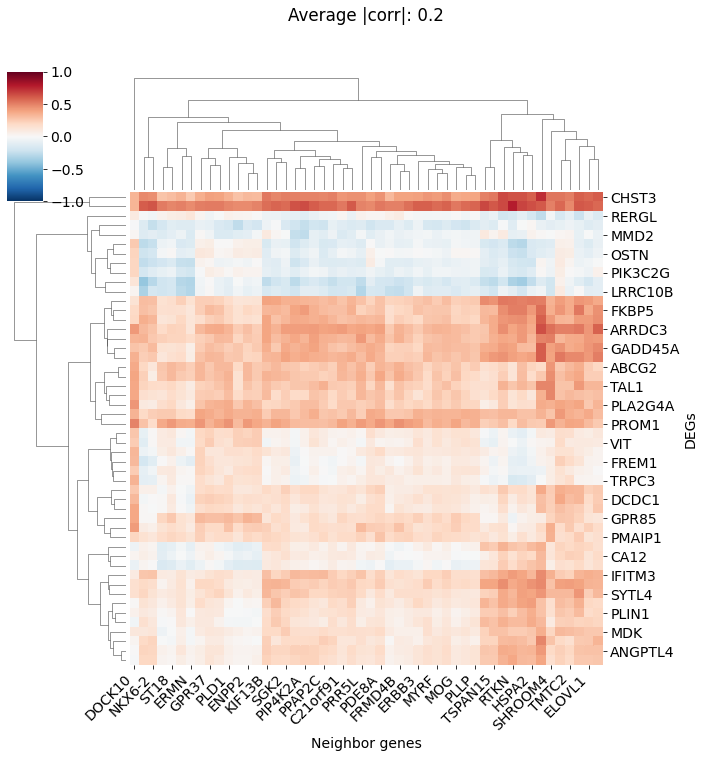

In [28]:
sorted_corr_df3 = plot_corr_data(gtex_important_genes, deg_list_convert, important_list_convert, 'neighbor')

## Corr4: Important genes vs DEGs with Kapoor expression data

In [67]:
expression_to_use2 = get_gene_expression(deg_list.tolist(), list(tom_important_genes.keys()), expression, gene_dict)

<Figure size 1008x792 with 0 Axes>

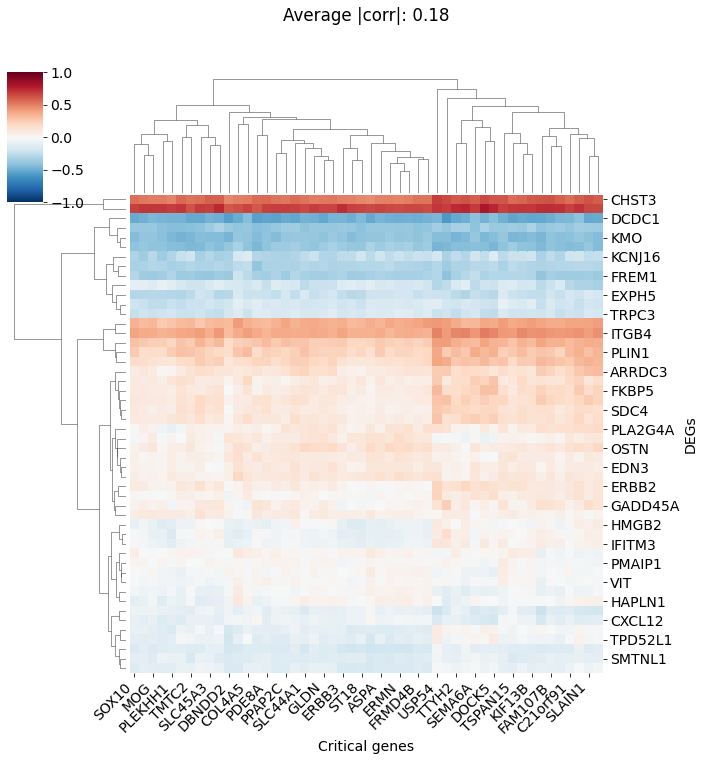

In [68]:
sorted_corr_df4 = plot_corr_data(expression_to_use2, deg_list_convert, important_list_convert, 'neighbor')

In [116]:
def plot_corr_dist(corr_df, expression_source, gene_list_name):
    plt.rcParams.update({'font.size':18})
    plt.hist(np.abs(corr_df).values.flatten(), alpha = 0.3, label = gene_list_name)
    plt.xlim(0, 1)
    plt.title(expression_source)
    plt.xlabel('Correlation coefficient')
    plt.ylabel('Events')
    plt.legend()

# KDE curve on CG vs DEGs. combine two gtex and two kapoor 

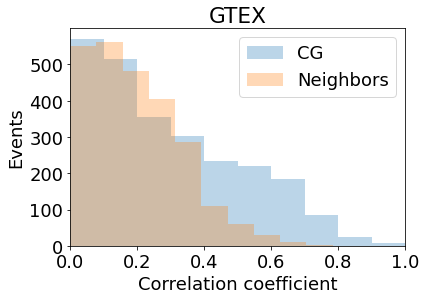

In [117]:
plot_corr_dist(sorted_corr_df1, 'GTEX', 'CG')
plot_corr_dist(sorted_corr_df3, 'GTEX', 'Neighbors')

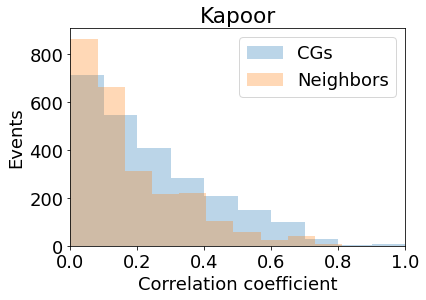

In [118]:
plot_corr_dist(sorted_corr_df2, 'Kapoor', 'CGs')
plot_corr_dist(sorted_corr_df4, 'Kapoor', 'Neighbors')

## Export a list of important genes to query IPA

In [20]:
tom_important_genes = get_network_important_genes(tom_w_deseq, cutoff = 0.0427)
print(len(tom_important_genes))
# sorted(tom_important_genes.items(), key=lambda kv: kv[1], reverse = True)

830


In [22]:
sorted_tom_important_genes = sorted(tom_important_genes.items(), key=lambda kv: kv[1], reverse = True)

In [29]:
important_gene_df = pd.DataFrame(sorted_tom_important_genes, columns = ['gene', 'near_DEG_cnt'])

In [31]:
important_gene_df.to_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\feature_extraction_derived\top_830_neighbor_genes.csv', index = 0)

In [45]:
print('overlap between important genes and critical genes')
len(set(important_gene_df.gene).intersection(set(critical_gene_df['gene'])))

overlap between important genes and critical genes


80

## Obtain neighbor genes from the mouse PFC network

In [14]:
pfc_tom = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/pipeline/mouse/network_analysis/tom.csv', index_col = 0) 
de_data = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/HDID_data/de_data.csv')
pfc_tom_w_deseq = join_network_w_deseq(pfc_tom, de_data)

In [21]:
deseq[deseq['abs_log2FC'] > 0.2].shape

(62, 9)

In [22]:
62/len(deseq)

0.004283542904518447

In [25]:
# calculate the cutoff that would be equivalent to 0.2 in the human data
de_data['abs_log2FC'].sort_values(ascending=False).reset_index(drop = True)[int(len(de_data)*0.004284)]

1.262871766

In [45]:
# get 645 same as # of critical genes
pfc_important_genes = get_network_important_genes(pfc_tom_w_deseq, cutoff = 0.0787, abs_log2FC_cutoff = 1.263)

In [46]:
sorted_pfc_important_genes = sorted(pfc_important_genes.items(), key=lambda kv: kv[1], reverse = True)

In [47]:
pfc_important_gene_df = pd.DataFrame(sorted_pfc_important_genes, columns = ['gene', 'near_DEG_cnt'])

In [48]:
pfc_important_gene_df.to_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\HDID_data\feature_extraction_derived\top_645_neighbor_genes.csv', index = 0)